In this analysis, it was used the data made available by the **Infodengue** (https://info.dengue.mat.br/) . It was used the data until the end of the 2021 year for the Rio de Janeiro city. 

The data is saved in the data folder. It was named as: `{disease}_{ibge_code}.csv` and assigned with `cluster` in the end when it refers to the clustered data. 

Let's look at the dengue and chik data for this case. Note that we have some statistics related to humidity, temperature, and the number of cases. These features will be used to forecast the number of dengue cases reported. 

In [1]:
import os 
import pickle
os.chdir('../')
import pandas as pd
from pgbm import qf_prediction
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from pgbm import  cross_dengue_chik_prediction
from datetime import datetime 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 3304557
CITY_NAME = 'Rio de Janeiro'
STATE = 'RJ'
END_DATE = '2015-11-01' # assign the last day used to train the dengue model
INI_DATE_CHIK = END_DATE # assign the first day used to retrain the model with chik data 
END_TRAIN_CHIK = '2016-04-01' # assign the last day used to retrain the model with chik data
END_DATE_CHIK = '2017-01-01' # assign the last day of chik data used to apply the trained model 
INI_EVALUATE = '2016-04-03' # assign the first day used to evaluate the trained model (transfer learning)
END_EVALUATE = '2016-05-08' # assign the last day used to evaluate the trained model (transfer learning)
PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 

In [3]:
df_dengue = pd.read_csv(f'./data/dengue_{CITY}.csv', index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,31,31.0,31,31.0,0.000000e+00,0.459408,24.333333,33.000000,42.000000,1009.666667
2010-01-10,45,45.0,45,45.0,0.000000e+00,0.666883,25.428571,34.000000,43.285714,1008.000000
2010-01-17,48,48.0,48,48.0,0.000000e+00,0.711341,24.142857,34.000000,43.857143,1010.285714
2010-01-24,56,56.0,56,56.0,0.000000e+00,0.829898,23.714286,34.285714,39.285714,1009.000000
2010-01-31,69,69.0,69,69.0,0.000000e+00,1.022553,23.857143,33.857143,41.285714,1009.857143
...,...,...,...,...,...,...,...,...,...,...
2022-06-05,229,255.0,240,278.0,5.712256e-08,3.779001,19.285714,24.428571,69.148006,1013.857143
2022-06-12,122,156.0,138,188.0,6.661338e-16,2.311859,17.571429,22.714286,71.092789,1013.714286
2022-06-19,156,204.0,180,248.0,6.709003e-03,3.023201,15.571429,23.000000,59.035306,1016.428571
2022-06-26,109,185.0,143,258.0,1.732266e-01,2.741628,17.285714,25.857143,58.679496,1016.857143


Note that the chik dataset has the same columns

In [4]:
df_chik = pd.read_csv(f'./data/chik_{CITY}.csv', index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,0,0.0,0,0,0.000000,0.000000,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.000000,0.000000,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.000000,0.000000,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.000000,0.000000,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.000000,0.000000,23.857143,33.857143,41.285714,1009.857143
...,...,...,...,...,...,...,...,...,...,...
2022-06-05,7,10.0,7,14,0.034802,0.148196,19.285714,24.428571,69.148006,1013.857143
2022-06-12,8,12.0,9,19,0.102687,0.177835,17.571429,22.714286,71.092789,1013.714286
2022-06-19,15,22.0,17,30,0.871627,0.326031,15.571429,23.000000,59.035306,1016.428571
2022-06-26,6,16.0,9,27,0.587232,0.237114,17.285714,25.857143,58.679496,1016.857143


The main difference between the datasets above and the datasets with names ended with `cluster` is the number of columns. This dataset has columns with data from other cities. The city is identified by a 7-number code. These cities was clusterized with Recife (in this case) using a hierarchical clusterization algorithm. 

In [5]:
df_chik_cluster = pd.read_csv(f'./data/chik_{CITY}_cluster.csv', index_col = 'Unnamed: 0' )
df_chik_cluster.index = pd.to_datetime(df_chik_cluster.index)
df_chik_cluster

,casos_3303203,casos_est_3303203,casos_est_min_3303203,casos_est_max_3303203,p_rt1_3303203,p_inc100k_3303203,temp_min_3303203,temp_max_3303203,umid_min_3303203,pressao_min_3303203,...,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,0,0.0,0,0,0.0,0.0,24.333333,33.000000,42.000000,1009.666667,...,0,0.0,0,0,0.000000,0.000000,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.0,25.428571,34.000000,43.285714,1008.000000,...,0,0.0,0,0,0.000000,0.000000,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.0,24.142857,34.000000,43.857143,1010.285714,...,0,0.0,0,0,0.000000,0.000000,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.0,23.714286,34.285714,39.285714,1009.000000,...,0,0.0,0,0,0.000000,0.000000,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.0,23.857143,33.857143,41.285714,1009.857143,...,0,0.0,0,0,0.000000,0.000000,23.857143,33.857143,41.285714,1009.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05,0,0.0,0,0,0.0,0.0,19.285714,24.428571,69.148006,1013.857143,...,7,10.0,7,14,0.034802,0.148196,19.285714,24.428571,69.148006,1013.857143
2022-06-12,0,0.0,0,0,0.0,0.0,17.571429,22.714286,71.092789,1013.714286,...,8,12.0,9,19,0.102687,0.177835,17.571429,22.714286,71.092789,1013.714286
2022-06-19,0,0.0,0,0,0.0,0.0,15.571429,23.000000,59.035306,1016.428571,...,15,22.0,17,30,0.871627,0.326031,15.571429,23.000000,59.035306,1016.428571
2022-06-26,0,0.0,0,0,0.0,0.0,17.285714,25.857143,58.679496,1016.857143,...,6,16.0,9,27,0.587232,0.237114,17.285714,25.857143,58.679496,1016.857143


We need to have this kind of data because, in our tests, the gradient boosting tree model perform betters when using the cluster data, while the neural network model performed better using only the city's data. 

Let's plot this two incidence curver (dengue and chik):

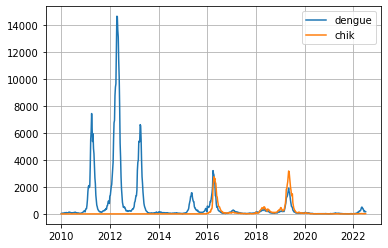

In [6]:
fig, ax = plt.subplots()

ax.plot(df_dengue[f'casos_est_{CITY}'], label = 'dengue')

ax.plot(df_chik[f'casos_est_{CITY}'], label = 'chik')

plt.legend()
plt.grid()
plt.show()

### Neural network model (NN)

First, we make the prediction using the data up to 2022-01-01 and use 25% data to test the model. It used 25% of the training data as validation data. It used the early stop config to train the model faster to monitor the loss function. 

Before applying the nn model we compute the first derivative of our target (the incidence curve) and added it as a feature. 

The neural newtork model is constructed using the `build_model` function. This function create a model with a bidirectional LSTM layer and a simple LSTM layer. We use the last 4 (look_back parameter) observations to predict the next 4 (predict_n parameter). 

The predictions of this models are saved in the path:
'./predictions/lstm/lstm_{city}_dengue_{label}.pkl'

The model is saved in the path: 
'./saved_models/lstm/trained_{geocode}_model_{label}.h5'

2022-08-31 13:58:11.732067: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 13:58:11.733609: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Compilation Time :  0.033683061599731445
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
__________________

2022-08-31 13:58:18.155237: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


168/168 [==============================] - 8s 46ms/sample - loss: 0.0273 - accuracy: 0.1607 - mape: 446.3583 - mse: 0.0485 - val_loss: 0.0110 - val_accuracy: 0.1607 - val_mape: 1743.4530 - val_mse: 0.0125
Epoch 2/100
168/168 [==============================] - 2s 14ms/sample - loss: 0.0149 - accuracy: 0.2560 - mape: 484.9014 - mse: 0.0286 - val_loss: 0.0021 - val_accuracy: 0.1607 - val_mape: 366.1503 - val_mse: 0.0027
Epoch 3/100
168/168 [==============================] - 2s 15ms/sample - loss: 0.0085 - accuracy: 0.2500 - mape: 145.4201 - mse: 0.0177 - val_loss: 8.0087e-04 - val_accuracy: 0.3214 - val_mape: 149.9307 - val_mse: 0.0010
Epoch 4/100
168/168 [==============================] - 2s 14ms/sample - loss: 0.0074 - accuracy: 0.4345 - mape: 142.5788 - mse: 0.0156 - val_loss: 0.0011 - val_accuracy: 0.3929 - val_mape: 152.6368 - val_mse: 0.0016
Epoch 5/100
168/168 [==============================] - 2s 14ms/sample - loss: 0.0062 - accuracy: 0.4048 - mape: 104.2665 - mse: 0.0126 - val_lo

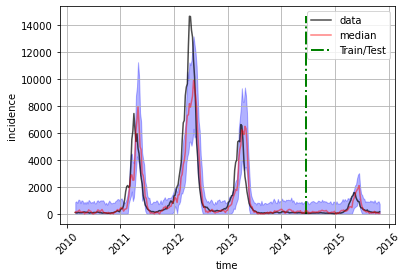

CPU times: user 5min 17s, sys: 19.8 s, total: 5min 37s
Wall time: 3min 46s


,0,1,2,3
mean_absolute_error,356.863815,348.115519,415.706424,5.426963e+02
explained_variance_score,0.918966,0.911800,0.865282,7.845449e-01
mean_squared_error,578730.220503,610899.320057,904761.773875,1.418136e+06
mean_squared_log_error,12.563893,9.026165,4.991698,1.420946e+00
median_absolute_error,133.538025,120.557601,109.000000,1.188655e+02
r2_score,0.910749,0.905783,0.860454,7.812548e-01


In [7]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 0.75, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle')

### PGBM model (ml) 

In this case, we use the last 4 observations to predict the next 4. Since a GBT (gradient boosting tree) model has a 1D target, we trained four different models each one specialized in predicting one of the next four observations.

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl'

The models are saved in the path:
'./saved_models/pgbm/{city}_{doenca}_city_model_{d}_pgbm.pt'
where d is in the arange 1 to 4. 


/opt/anaconda3/envs/alerta_dengue/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 2602.5395
Estimator 1/100, Train metric: 2378.3050
Estimator 2/100, Train metric: 2174.0969
Estimator 3/100, Train metric: 1985.5780
Estimator 4/100, Train metric: 1815.2614
Estimator 5/100, Train metric: 1656.5963
Estimator 6/100, Train metric: 1516.8620
Estimator 7/100, Train metric: 1388.1853
Estimator 8/100, Train metric: 1271.8738
Estimator 9/100, Train metric: 1163.9772
Estimator 10/100, Train metric: 1067.3221
Estimator 11/100, Train metric: 978.6316
Estimator 12/100, Train metric: 897.8164
Estimator 13/100, Train metric: 824.4804
Estimator 14/100, Train metric: 757.1851
Estimator 15/100, Train metric: 696.5586
Estimator 16/100, Train metric: 640.7884
Estimator 17/100, Train metric: 589.9119
Estimator 18/100, Train metric: 542.7294
Estimator 19/100, Train metric: 499.8094
Estimator 20/100, Train metric: 460.7320
Estimator 21/100, Train metric: 425.0693
Estimator 22/100, Train metric: 392.6949
Estimator 23/100, Train metric: 362.9764
Estimator 24/10

Estimator 6/100, Train metric: 1546.6420
Estimator 7/100, Train metric: 1419.4454
Estimator 8/100, Train metric: 1299.1615
Estimator 9/100, Train metric: 1190.0559
Estimator 10/100, Train metric: 1091.1940
Estimator 11/100, Train metric: 1000.3278
Estimator 12/100, Train metric: 917.5970
Estimator 13/100, Train metric: 845.3044
Estimator 14/100, Train metric: 777.3038
Estimator 15/100, Train metric: 715.4606
Estimator 16/100, Train metric: 659.4326
Estimator 17/100, Train metric: 607.5887
Estimator 18/100, Train metric: 560.7665
Estimator 19/100, Train metric: 518.7547
Estimator 20/100, Train metric: 478.9195
Estimator 21/100, Train metric: 442.8655
Estimator 22/100, Train metric: 409.9085
Estimator 23/100, Train metric: 379.8728
Estimator 24/100, Train metric: 352.3610
Estimator 25/100, Train metric: 325.2276
Estimator 26/100, Train metric: 302.1808
Estimator 27/100, Train metric: 281.1450
Estimator 28/100, Train metric: 259.6907
Estimator 29/100, Train metric: 239.9624
Estimator 30/1

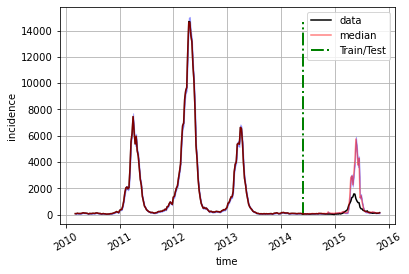

CPU times: user 3min 41s, sys: 41.7 s, total: 4min 23s
Wall time: 58.9 s


In [8]:
%%time

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE)
   

### Comparing the Neural and ML model 

In this section we compare the performance of the ML and NN model. 

In [9]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_msle.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_{doenca}_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

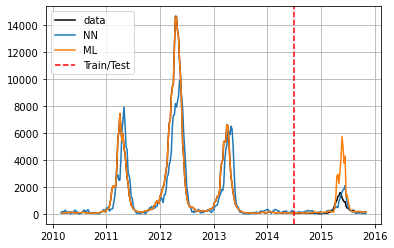

In [10]:
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.axvline(data_ml['dates'][data_ml['train_size']], color = 'red', ls = '--', label = 'Train/Test') # refered to the ML model 

plt.grid()
plt.legend()
plt.show()

Let's compare the error of this models in the test data: 

In [11]:
print('NN error (RMSE):', mse(data_nn['target'][data_nn['xdata'].shape[0]:, -1] * data_nn['factor'], data_nn['pred'].iloc[data_nn['xdata'].shape[0]:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4+ data_ml['train_size']:], data_ml['preds'][data_ml['train_size']:], squared = False))

NN error (RMSE): 285.68382726499857
ML error (RMSE): 1018.4568747068469


Looking at the error above we can see that besides comsume more time training, the neural network model (nn) outperform the machine learning model (ml)

We will know use this models to predict the chik outbreak in 2021. In order to do this, we will retrain the nn model and the ml model using the dengue data up to '2021-01-01' and apply the model in the chik data between '2021-01-01' and '2022-01-01'

The label parameter is used as a flag to make difference, if necessary, between the models saved, since this model takes a lot of time to be trained


Compilation Time :  0.0375518798828125
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
__________________

2022-08-31 14:03:04.567443: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


222/222 [==============================] - 10s 43ms/sample - loss: 0.0192 - accuracy: 0.3108 - mape: 421.7147 - mse: 0.0339 - val_loss: 0.0056 - val_accuracy: 0.2667 - val_mape: 1591.2113 - val_mse: 0.0062
Epoch 2/100
222/222 [==============================] - 3s 14ms/sample - loss: 0.0073 - accuracy: 0.1802 - mape: 233.1741 - mse: 0.0146 - val_loss: 0.0021 - val_accuracy: 0.2133 - val_mape: 576.7078 - val_mse: 0.0024
Epoch 3/100
222/222 [==============================] - 3s 14ms/sample - loss: 0.0051 - accuracy: 0.3063 - mape: 149.4128 - mse: 0.0100 - val_loss: 6.2406e-04 - val_accuracy: 0.2933 - val_mape: 250.7531 - val_mse: 7.0148e-04
Epoch 4/100
222/222 [==============================] - 4s 20ms/sample - loss: 0.0048 - accuracy: 0.3739 - mape: 148.2535 - mse: 0.0095 - val_loss: 6.7587e-04 - val_accuracy: 0.3200 - val_mape: 281.9887 - val_mse: 7.5490e-04
Epoch 5/100
222/222 [==============================] - 8s 37ms/sample - loss: 0.0048 - accuracy: 0.3378 - mape: 136.7039 - mse: 0.

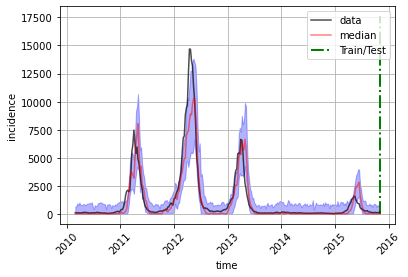

CPU times: user 11min 4s, sys: 53.1 s, total: 11min 57s
Wall time: 8min 1s


,0,1,2,3
mean_absolute_error,288.481443,344.670037,396.747734,4.756377e+02
explained_variance_score,0.959034,0.931663,0.897913,8.431835e-01
mean_squared_error,303726.000560,483888.586114,703995.065936,1.053794e+06
mean_squared_log_error,13.262520,13.738073,13.736324,1.208027e+01
median_absolute_error,129.000000,142.000000,142.000000,1.380091e+02
r2_score,0.953160,0.925371,0.891419,8.374540e-01


In [12]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back= LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'msle_all')

Estimator 0/100, Train metric: 2319.9609
Estimator 1/100, Train metric: 2121.1182
Estimator 2/100, Train metric: 1937.3875
Estimator 3/100, Train metric: 1771.4562
Estimator 4/100, Train metric: 1619.5707
Estimator 5/100, Train metric: 1482.9705
Estimator 6/100, Train metric: 1357.6553
Estimator 7/100, Train metric: 1242.3904
Estimator 8/100, Train metric: 1138.3628
Estimator 9/100, Train metric: 1042.9754
Estimator 10/100, Train metric: 956.5124
Estimator 11/100, Train metric: 877.6641
Estimator 12/100, Train metric: 805.5383
Estimator 13/100, Train metric: 739.8481
Estimator 14/100, Train metric: 679.3614
Estimator 15/100, Train metric: 624.6798
Estimator 16/100, Train metric: 574.9296
Estimator 17/100, Train metric: 529.1092
Estimator 18/100, Train metric: 486.8335
Estimator 19/100, Train metric: 448.3580
Estimator 20/100, Train metric: 412.9803
Estimator 21/100, Train metric: 380.6989
Estimator 22/100, Train metric: 351.2966
Estimator 23/100, Train metric: 324.5069
Estimator 24/100

Estimator 5/100, Train metric: 1506.6631
Estimator 6/100, Train metric: 1382.0509
Estimator 7/100, Train metric: 1268.5879
Estimator 8/100, Train metric: 1164.9979
Estimator 9/100, Train metric: 1070.9844
Estimator 10/100, Train metric: 984.7981
Estimator 11/100, Train metric: 906.2276
Estimator 12/100, Train metric: 831.1473
Estimator 13/100, Train metric: 762.9030
Estimator 14/100, Train metric: 700.6615
Estimator 15/100, Train metric: 644.3145
Estimator 16/100, Train metric: 591.8828
Estimator 17/100, Train metric: 544.7675
Estimator 18/100, Train metric: 501.9309
Estimator 19/100, Train metric: 461.6511
Estimator 20/100, Train metric: 426.1744
Estimator 21/100, Train metric: 392.6472
Estimator 22/100, Train metric: 362.0924
Estimator 23/100, Train metric: 335.7391
Estimator 24/100, Train metric: 310.0415
Estimator 25/100, Train metric: 287.1756
Estimator 26/100, Train metric: 266.3525
Estimator 27/100, Train metric: 247.4638
Estimator 28/100, Train metric: 230.1037
Estimator 29/100

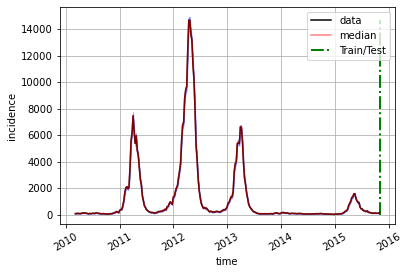

In [13]:

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE)
   

Apply the ml model in chik:

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl'

/opt/anaconda3/envs/alerta_dengue/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


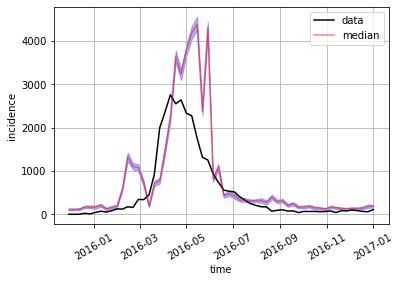

In [17]:

preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE_CHIK, end_date = END_DATE_CHIK)
    

Apply the NN model into the chik data:

The predictions is saved in the path: './predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl'

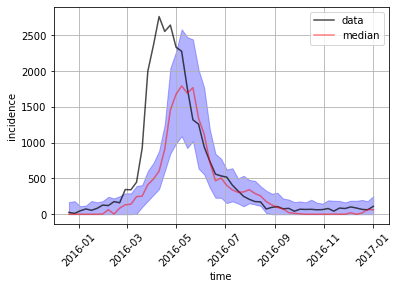

In [18]:

metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'msle_all' )

Compare the predictions:

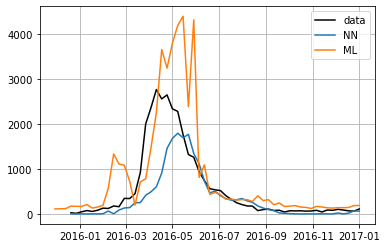

In [19]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.show()

Compute the RMSE error: 

In [20]:

print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 547.4996604365248
ML error (RMSE): 732.185778668497


### Transfer learning 

Here we use the transfer learning technique to improve the performance of the predictions of the dengue model in the chik data. To do this, we retrain the output layer of the dengue model, and after it, retrain the model (all the layers, that's the fine tunning step). In this step, we need to pay attention to overfitting. It can be necessary to decrease the learning rate. 

We use the transfer learning technique since it is not possible to train a good ml or nn model with few observations, as in the case of the  chik outbreak in Recife in 2021. 

2022-08-31 15:54:36.767653: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 15:54:36.768429: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Compilation Time :  0.03040599822998047
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
__________________

2022-08-31 15:54:41.193696: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


15/15 [==============================] - 4s 278ms/sample - loss: 0.0105 - accuracy: 0.3333 - mape: 129.7171 - mse: 0.0156
Epoch 2/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0096 - accuracy: 0.3333 - mape: 225.2993 - mse: 0.0145
Epoch 3/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0093 - accuracy: 0.4667 - mape: 238.9948 - mse: 0.0141
Epoch 4/100
15/15 [==============================] - 0s 12ms/sample - loss: 0.0086 - accuracy: 0.8000 - mape: 264.5429 - mse: 0.0133
Epoch 5/100
15/15 [==============================] - 0s 12ms/sample - loss: 0.0081 - accuracy: 0.6667 - mape: 383.0325 - mse: 0.0127
Epoch 6/100
15/15 [==============================] - 0s 12ms/sample - loss: 0.0083 - accuracy: 0.5333 - mape: 411.3839 - mse: 0.0130
Epoch 7/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0075 - accuracy: 0.5333 - mape: 383.1626 - mse: 0.0120
Epoch 8/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.00

2022-08-31 15:54:56.263259: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


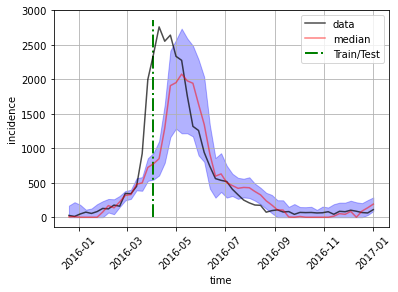

In [3]:
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'./saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = 'msle', validation_split = 0.0,
                            label = f'transf_chik')

To apply the transfer learning technique we use as train data the chik data up to '2021-05-01'. We can see that after this day the model has good performance considering the next month (data between '2021-05-01' and '2021-06-01'). 

To evaluate the improvement in the performance of the model we compute the following skill score: 

$$ SS = 1 - \cfrac{RMSE_{forecast}}{RMSE_{reference}}$$ 

In the formula, the reference represent the error of the model used as reference and the forecast represent the new model that we want to compare the performance. If the SS value is above 0 or new model is better than the reference model, otherwise it's worst.

In [4]:
def ss(forecast, reference, target):
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)

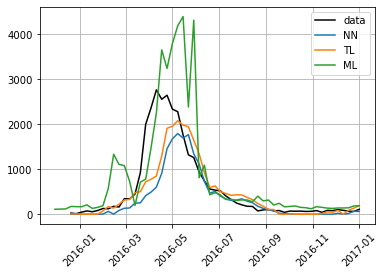

In [5]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [6]:
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: 0.18487410918353364
SS compared to ML: -0.33687759814677753


### Retrain the dengue model with a custom loss function 

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

In [10]:
from lstm import custom_loss_msle

Compilation Time :  0.03920412063598633
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
_________________

2022-08-31 14:12:55.965754: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


222/222 [==============================] - 10s 44ms/sample - loss: 0.1151 - accuracy: 0.2027 - mape: 380.5333 - mse: 0.0402 - val_loss: 0.0170 - val_accuracy: 0.1733 - val_mape: 1152.4139 - val_mse: 0.0032
Epoch 2/100
222/222 [==============================] - 3s 14ms/sample - loss: 0.0742 - accuracy: 0.3063 - mape: 399.4124 - mse: 0.0270 - val_loss: 0.0205 - val_accuracy: 0.2800 - val_mape: 1079.7657 - val_mse: 0.0042
Epoch 3/100
222/222 [==============================] - 3s 15ms/sample - loss: 0.0292 - accuracy: 0.3243 - mape: 229.6591 - mse: 0.0125 - val_loss: 0.0042 - val_accuracy: 0.3867 - val_mape: 284.8538 - val_mse: 0.0012
Epoch 4/100
222/222 [==============================] - 3s 15ms/sample - loss: 0.0283 - accuracy: 0.3559 - mape: 156.9827 - mse: 0.0137 - val_loss: 0.0037 - val_accuracy: 0.2667 - val_mape: 192.2141 - val_mse: 0.0014
Epoch 5/100
222/222 [==============================] - 3s 14ms/sample - loss: 0.0219 - accuracy: 0.3694 - mape: 131.8792 - mse: 0.0135 - val_loss

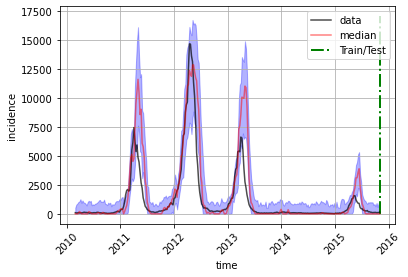

CPU times: user 8min 46s, sys: 1min 2s, total: 9min 48s
Wall time: 6min 4s


,0,1,2,3
mean_absolute_error,390.898586,422.744311,5.500631e+02,7.143141e+02
explained_variance_score,0.896732,0.873058,7.789713e-01,6.083879e-01
mean_squared_error,680000.803264,827012.423945,1.492581e+06,2.715345e+06
mean_squared_log_error,13.533787,12.320643,1.125615e+01,9.723061e+00
median_absolute_error,133.000000,115.000000,1.240000e+02,1.330000e+02
r2_score,0.895132,0.872452,7.697915e-01,5.811624e-01


In [23]:
%%time
model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back = LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1.0, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'custom_msle')

See the behaviour of this model when applied in the chik data:

2022-08-31 15:41:48.729561: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 15:41:48.730552: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


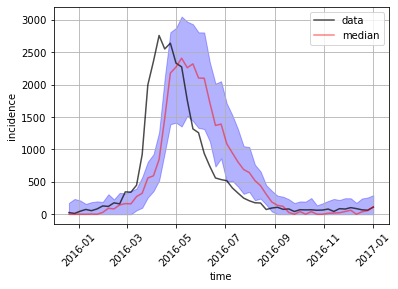

CPU times: user 27 s, sys: 1.77 s, total: 28.8 s
Wall time: 15.1 s


In [6]:
%%time
metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'custom_msle' )

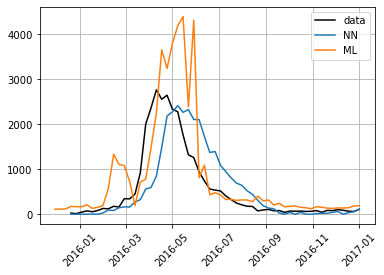

In [7]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [8]:
print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 571.1079932072987
ML error (RMSE): 732.185778668497


Apply the transfer learning technique using this new trained model:

Compilation Time :  0.034584999084472656
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
_______________

2022-08-31 16:03:28.376412: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


15/15 [==============================] - 4s 287ms/sample - loss: 0.1109 - accuracy: 0.2667 - mape: 194.9830 - mse: 0.0163
Epoch 2/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.1025 - accuracy: 0.4000 - mape: 220.6480 - mse: 0.0153
Epoch 3/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.0969 - accuracy: 0.4667 - mape: 342.1976 - mse: 0.0147
Epoch 4/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.0925 - accuracy: 0.5333 - mape: 380.1160 - mse: 0.0142
Epoch 5/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.0868 - accuracy: 0.6000 - mape: 397.8911 - mse: 0.0135
Epoch 6/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.0835 - accuracy: 0.5333 - mape: 359.3974 - mse: 0.0131
Epoch 7/100
15/15 [==============================] - 0s 11ms/sample - loss: 0.0788 - accuracy: 0.6000 - mape: 309.6628 - mse: 0.0125
Epoch 8/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.07

15/15 [==============================] - 0s 13ms/sample - loss: 0.0230 - accuracy: 0.5333 - mape: 110.2858 - mse: 0.0045  
Epoch 63/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0223 - accuracy: 0.6667 - mape: 151.0002 - mse: 0.0040
Epoch 64/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0216 - accuracy: 0.5333 - mape: 174.1997 - mse: 0.0042
Epoch 65/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0239 - accuracy: 0.4667 - mape: 152.5126 - mse: 0.0045  
Epoch 66/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0165 - accuracy: 0.6000 - mape: 77.2312 - mse: 0.0032
Epoch 67/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0171 - accuracy: 0.6000 - mape: 150.7374 - mse: 0.0034
Epoch 68/100
15/15 [==============================] - 0s 13ms/sample - loss: 0.0150 - accuracy: 0.6000 - mape: 65.8849 - mse: 0.0029
Epoch 69/100
15/15 [==============================] - 0s 13ms/sample - lo

2022-08-31 16:03:47.722990: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


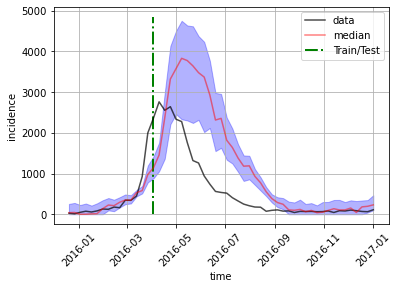

CPU times: user 1min 13s, sys: 6.1 s, total: 1min 19s
Wall time: 47 s


In [11]:
%%time
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'./saved_models/lstm/trained_{CITY}_model_custom_msle.h5',  epochs =100, features = 11,  
                            predict_n = PREDICT_N, look_back = LOOK_BACK, loss = custom_loss_msle(p=10), validation_split = 0.0,
                            label = f'transf_chik')

Comparing the predictions of the NN (neural network), the TL (transfer learning) and the ML (machine learning) model:

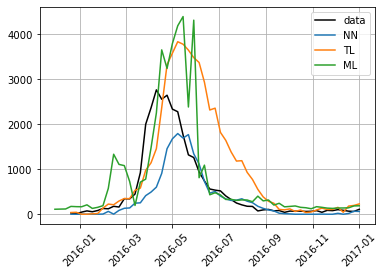

In [12]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [13]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: 0.35839126266395405
SS compared to ML: -0.05229432334757145
